# Time-varying Wind Profile

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import sys
import time
sql_table = pd.DataFrame()
for i in range(20, 70, 10):
    conn = sqlite3.connect(f'../input/wind/energy_and_flight_time_{i}_mile_route.sqlite')
    query = """
    SELECT flight_direction, energy_consumption, flight_time, wind_direction_degrees, wind_magnitude_mph
    FROM flight_metrics
    """
    df = pd.read_sql_query(query, conn)
    df['distance'] = i

    sql_table = pd.concat([sql_table, df])  
sql_table = sql_table.reset_index(drop=True)
data_dict = {}

for i in range(0, len(sql_table), 2):
    k1 = sql_table['energy_consumption'][i]
    k2 = sql_table['energy_consumption'][i+1]
    kappa = np.array([[0, k1],[k2, 0]])/160*100

    t1 = sql_table['flight_time'][i]
    t2 = sql_table['flight_time'][i+1]
    tau = np.array([[0, t1],[t2, 0]])

    distance = sql_table['distance'][i]
    wind_direction_degrees = sql_table['wind_direction_degrees'][i]
    wind_magnitude_mph = sql_table['wind_magnitude_mph'][i]

    key = (distance, wind_direction_degrees, wind_magnitude_mph)
    data_dict[key] = {'flight_time': tau, 'energy_consumption': kappa}

In [2]:
sql_table[sql_table['distance'] == 40]

,flight_direction,energy_consumption,flight_time,wind_direction_degrees,wind_magnitude_mph,distance
52,SFO_SJC,33.280233,16.918017,0,0,40
53,SJC_SFO,33.276888,16.916033,0,0,40
54,SFO_SJC,32.407714,16.355918,0,10,40
55,SJC_SFO,32.404547,16.354039,0,10,40
56,SFO_SJC,33.307728,16.934703,90,10,40
57,SJC_SFO,33.304377,16.932716,90,10,40
58,SFO_SJC,34.380246,17.546912,180,10,40
59,SJC_SFO,34.376702,17.544810,180,10,40
60,SFO_SJC,31.759419,15.850508,0,20,40
61,SJC_SFO,31.756411,15.848724,0,20,40


# Create wind profiles

In [3]:
flight_schedule = pd.read_csv("../input/ICRAT/schedule_1500pax_5min_0125.csv")
occupancy = pd.read_csv("../input/ICRAT/num_pax_1500pax_5min_0125.csv")

In [4]:
kappa = np.array([data_dict[40,0,0]['energy_consumption'], data_dict[40,180,40]['energy_consumption'] ,data_dict[40,0,40]['energy_consumption']])
tau = np.array([data_dict[40,0,0]['flight_time'], data_dict[40,180,40]['flight_time'],data_dict[40,0,40]['flight_time']])
flight_time = np.vstack([np.repeat(tau[0:1], 100, axis=0), np.repeat(tau[1:2], 100, axis=0), np.repeat(tau[2:3], 89, axis=0)])
energy_consumption = np.vstack([np.repeat(kappa[0:1], 100, axis=0), np.repeat(kappa[1:2], 100, axis=0), np.repeat(kappa[2:3], 89, axis=0)])

In [5]:
import os
os.chdir('../')
os.environ['GRB_LICENSE_FILE'] = '../gurobipy/gurobi.lic'
import importlib
from model.op import FleetSizeOptimizer
import gurobipy as gp

In [7]:
op = FleetSizeOptimizer(flight_time=flight_time, energy_consumption=energy_consumption, schedule="../input/ICRAT/schedule_1500pax_5min_0125.csv")
# optimal_fleet_size = op.optimize(output_path='output/ICRAT_wind_variation/wind_test/wind_profile_1')
optimal_fleet_size = 28
for i in range(int(optimal_fleet_size-3), 26):
    print(f'Spill optimization for fleet size: {i}/{optimal_fleet_size}')
    op.optimize(output_path=f'output/ICRAT_wind_variation/wind_test/wind_profile_1_fleetsize_{i}', spill_optimization=True,
                seat_capacity=4, 
                occupancy=occupancy, fleet_size=i, optimality_gap=0.1)

Spill optimization for fleet size: 25/28
Set parameter MIPGap to value 0.1
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6326 CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 32 physical cores, 64 logical processors, using up to 32 threads

Optimize a model with 22219 rows, 348670 columns and 684150 nonzeros
Model fingerprint: 0xd2dc2424
Variable types: 0 continuous, 348670 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 2663 rows and 31820 columns
Presolve time: 1.04s
Presolved: 19556 rows, 316850 columns, 645100 nonzeros
Variable types: 0 continuous, 316850 integer (18 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.76s

Bar

In [8]:
op.parse_result('ICRAT_wind_variation/wind_test/wind_profile_1_fleet_op_result.txt')

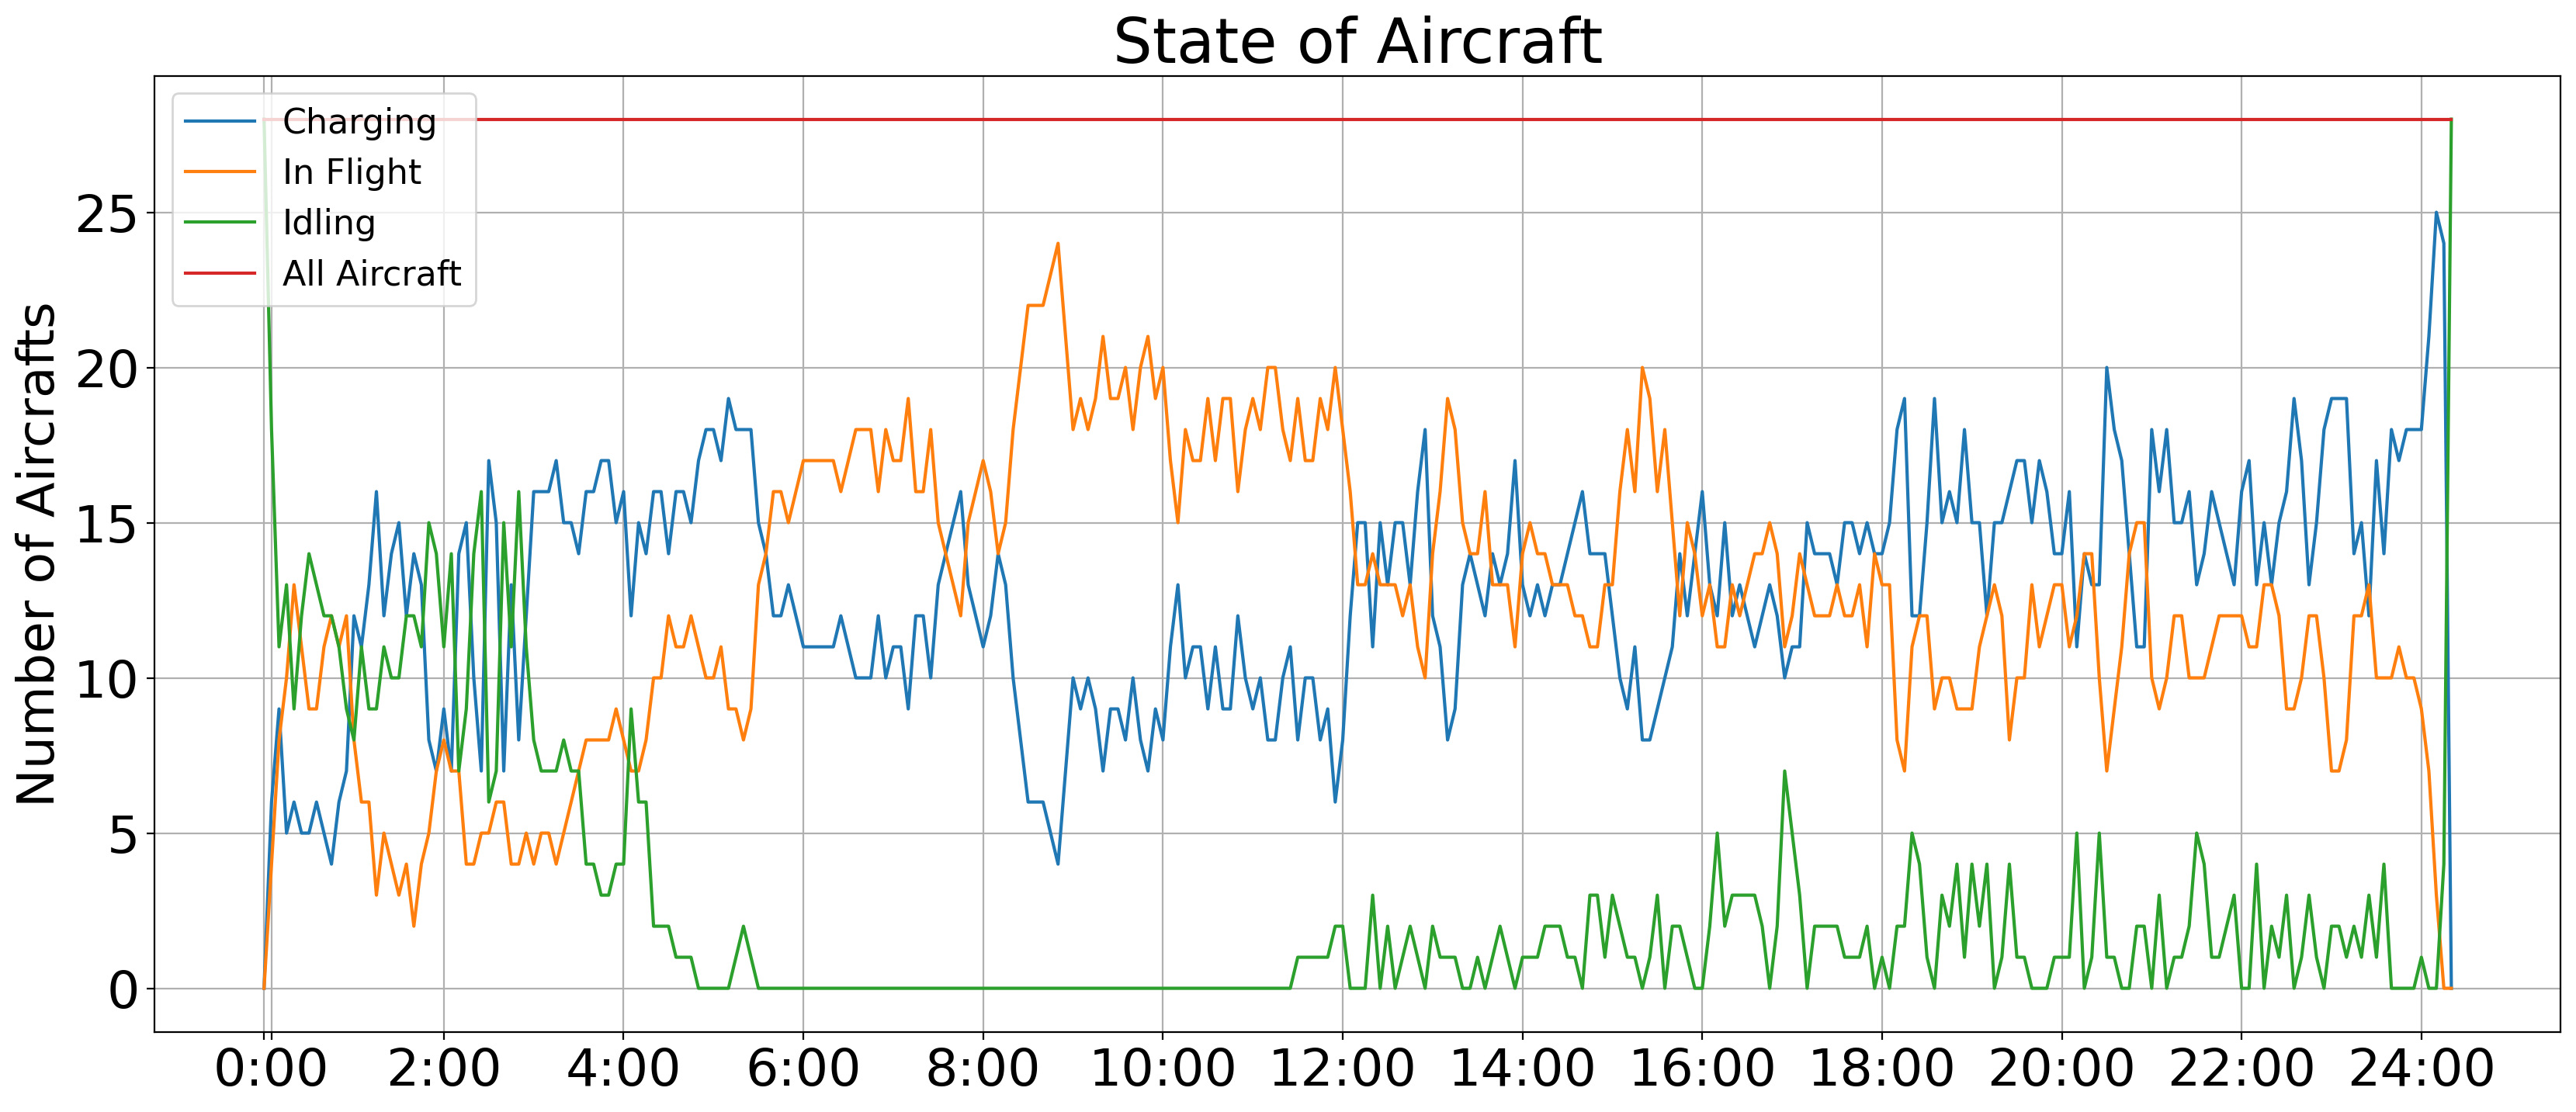

In [9]:
op.calculate_aircraft_states()
op.plot_aircraft_state()